**Import Python libraries**

In [1]:
import numpy as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


**Load The dataset**

In [8]:
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10,6)

# change the filename/path if needed
df = pd.read_csv("/content/pharma-data.csv", encoding="utf-8")
print("Loaded shape:", df.shape)
df.head()


Loaded shape: (254082, 18)


,Distributor,Customer Name,City,Country,Latitude,Longitude,Channel,Sub-channel,Product Name,Product Class,Quantity,Price,Sales,Month,Year,Name of Sales Rep,Manager,Sales Team
0,Gottlieb-Cruickshank,"Zieme, Doyle and Kunze",Lublin,Poland,51.2333,22.5667,Hospital,Private,Topipizole,Mood Stabilizers,4.0,368,1472.0,January,2018,Mary Gerrard,Britanny Bold,Delta
1,Gottlieb-Cruickshank,Feest PLC,Świecie,Poland,53.4167,18.4333,Pharmacy,Retail,Choriotrisin,Antibiotics,7.0,591,4137.0,January,2018,Jessica Smith,Britanny Bold,Delta
2,Gottlieb-Cruickshank,Medhurst-Beer Pharmaceutical Limited,Rybnik,Poland,50.0833,18.5000,Pharmacy,Institution,Acantaine,Antibiotics,30.0,66,1980.0,January,2018,Steve Pepple,Tracy Banks,Bravo
3,Gottlieb-Cruickshank,Barton Ltd Pharma Plc,Czeladź,Poland,50.3333,19.0833,Hospital,Private,Lioletine Refliruvax,Analgesics,6.0,435,2610.0,January,2018,Mary Gerrard,Britanny Bold,Delta
4,Gottlieb-Cruickshank,Keeling LLC Pharmacy,Olsztyn,Poland,53.7800,20.4942,Pharmacy,Retail,Oxymotroban Fexoformin,Analgesics,20.0,458,9160.0,January,2018,Anne Wu,Britanny Bold,Delta


**Clean column names & simple renames**

In [9]:
df.columns = df.columns.str.strip()                # remove stray spaces
rename_map = {
    "Name of Sales Rep":"Sales_Rep",
    "Customer Name":"Customer_Name",
    "Product Name":"Product_Name",
    "Product Class":"Product_Class",
    "Sales Team":"Sales_Team",
    "Month":"Month",
    "Year":"Year"
}
# only rename keys that exist
existing_map = {k:v for k,v in rename_map.items() if k in df.columns}
df = df.rename(columns=existing_map)

print("Columns now:", df.columns.tolist())

Columns now: ['Distributor', 'Customer_Name', 'City', 'Country', 'Latitude', 'Longitude', 'Channel', 'Sub-channel', 'Product_Name', 'Product_Class', 'Quantity', 'Price', 'Sales', 'Month', 'Year', 'Sales_Rep', 'Manager', 'Sales_Team']


**Convert Quantity / Price / Sales to numeric**

In [10]:
for col in ["Quantity","Price","Sales"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(r"[^\d\.\-]", "", regex=True), errors="coerce")

# quick check
print(df[["Quantity","Price","Sales"]].dtypes)
df[["Quantity","Price","Sales"]].head()

Quantity    float64
Price         int64
Sales       float64
dtype: object


,Quantity,Price,Sales
0,4.0,368,1472.0
1,7.0,591,4137.0
2,30.0,66,1980.0
3,6.0,435,2610.0
4,20.0,458,9160.0


**Build a Date column from Month + Year (robust)**

In [11]:
if ("Month" in df.columns) and ("Year" in df.columns):
    month_s = df["Month"].astype(str).str.strip()
    year_s = df["Year"].astype(str).str.strip()
    # try parsing strings like "Jan 2023" or "January 2023"
    df["Date"] = pd.to_datetime(month_s + " " + year_s, errors="coerce")
    # fallback: if Month is numeric (1-12)
    mask = df["Date"].isna()
    if mask.any():
        month_int = pd.to_numeric(month_s, errors="coerce")
        year_int  = pd.to_numeric(year_s, errors="coerce")
        df.loc[mask, "Date"] = pd.to_datetime(year_int.astype("Int64").astype(str) + "-" + month_int.astype("Int64").astype(str) + "-01", errors="coerce")
    print("Date column created. NaT count:", df["Date"].isna().sum())
else:
    print("Month or Year column missing; Date not created.")

Date column created. NaT count: 0


/tmp/ipython-input-1970894884.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(month_s + " " + year_s, errors="coerce")


**Missing values summary & simple decisions**

In [13]:
missing = df.isna().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)
pd.concat([missing, missing_percent], axis=1).rename(columns={0:"missing_count",1:"missing_percent"}).head(7)

,missing_count,missing_percent
Distributor,0,0.0
Customer_Name,0,0.0
City,0,0.0
Country,0,0.0
Latitude,0,0.0
Longitude,0,0.0
Channel,0,0.0


**Quick cleaning example (drop rows with missing Sales)**

In [14]:
if "Sales" in df.columns:
    before = len(df)
    df = df[~df["Sales"].isna()].copy()
    print(f"Dropped {before - len(df)} rows with missing Sales; remaining rows = {len(df)}")
# fill Quantity missing with 0 as a simple choice (adjust if you prefer median)
if "Quantity" in df.columns:
    df["Quantity"] = df["Quantity"].fillna(0)

Dropped 0 rows with missing Sales; remaining rows = 254082


**KPIs (single-number summaries)**

In [15]:
total_sales = df["Sales"].sum() if "Sales" in df.columns else np.nan
total_qty = df["Quantity"].sum() if "Quantity" in df.columns else np.nan
avg_price = df["Price"].mean() if "Price" in df.columns else np.nan
unique_customers = df["Customer_Name"].nunique() if "Customer_Name" in df.columns else np.nan
unique_products = df["Product_Name"].nunique() if "Product_Name" in df.columns else np.nan
date_range = (df["Date"].min(), df["Date"].max()) if "Date" in df.columns else (None,None)

print(f"Total Sales: {total_sales:,.2f}")
print(f"Total Quantity Sold: {total_qty:,.0f}")
print(f"Average Price: {avg_price:,.2f}")
print(f"Unique Customers: {unique_customers}")
print(f"Unique Products: {unique_products}")
print("Date range:", date_range)

Total Sales: 11,798,987,642.20
Total Quantity Sold: 28,678,779
Average Price: 412.21
Unique Customers: 751
Unique Products: 240
Date range: (Timestamp('2017-01-01 00:00:00'), Timestamp('2020-12-01 00:00:00'))


**Monthly sales trend + moving average (line plot)**

/tmp/ipython-input-2068309413.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index("Date").resample("M")["Sales"].sum().reset_index()
/tmp/ipython-input-2068309413.py:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


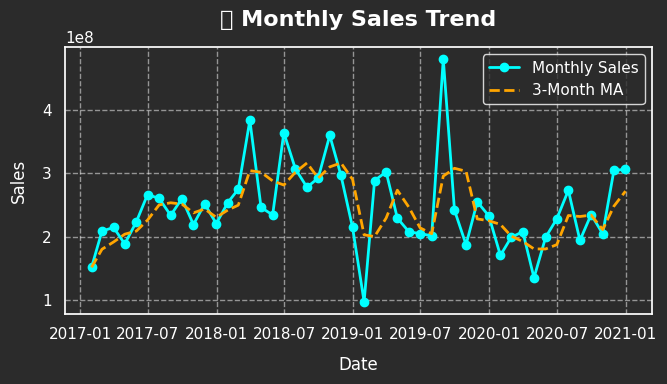

In [79]:
if "Date" in df.columns:
    monthly = df.set_index("Date").resample("M")["Sales"].sum().reset_index()
    monthly["MA_3"] = monthly["Sales"].rolling(3, min_periods=1).mean()

    fig, ax = plt.subplots(figsize=(7,4))

    # 🔹 Set figure + axes background
    fig.patch.set_facecolor("#2b2b2b")   # whole figure background
    ax.set_facecolor("#2b2b2b")          # only plotting area

    # Sales line
    ax.plot(monthly["Date"], monthly["Sales"],
             marker="o", color="cyan", linewidth=2, label="Monthly Sales")

    # Moving average line
    ax.plot(monthly["Date"], monthly["MA_3"],
             linestyle="--", color="orange", linewidth=2, label="3-Month MA")

    # Title and labels (WHITE so it's visible)
    ax.set_title("📈 Monthly Sales Trend", fontsize=16, fontweight="bold", color="white", pad=15)
    ax.set_xlabel("Date", fontsize=12, color="white", labelpad=10)
    ax.set_ylabel("Sales", fontsize=12, color="white", labelpad=10)

    # X & Y ticks
    ax.tick_params(colors="white")

    # Legend styling
    legend = ax.legend(facecolor="#2b2b2b", edgecolor="white")
    for text in legend.get_texts():
        text.set_color("white")

    # Grid
    ax.grid(True, linestyle="--", alpha=0.5, color="white")

    plt.tight_layout()
    plt.show()


**Top products**

/tmp/ipython-input-2003950061.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2003950061.py:29: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


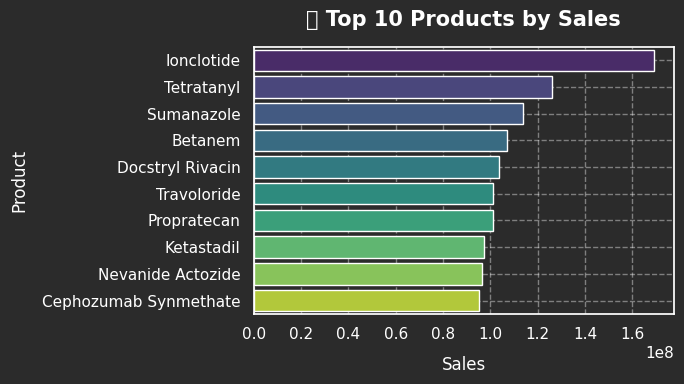

In [81]:
if "Product_Name" in df.columns:
    top_products = df.groupby("Product_Name")["Sales"].sum().sort_values(ascending=False).head(10)

    fig, ax = plt.subplots(figsize=(7,4))

    # 🔹 Set figure + axes background
    fig.patch.set_facecolor("#2b2b2b")
    ax.set_facecolor("#2b2b2b")

    # Barplot
    sns.barplot(
        x=top_products.values,
        y=top_products.index,
        palette="viridis",   # 🔹 you can change to "coolwarm", "Set2", "magma", etc.
        ax=ax
    )

    # Titles and labels
    ax.set_title("🏆 Top 10 Products by Sales", fontsize=15, fontweight="bold", color="white", pad=15)
    ax.set_xlabel("Sales", fontsize=12, color="white", labelpad=10)
    ax.set_ylabel("Product", fontsize=12, color="white", labelpad=10)

    # Tick labels
    ax.tick_params(colors="white")

    # Grid
    ax.grid(True, linestyle="--", alpha=0.4, color="white")

    plt.tight_layout()
    plt.show()


**Pie Chart — Sales Share by Channel**

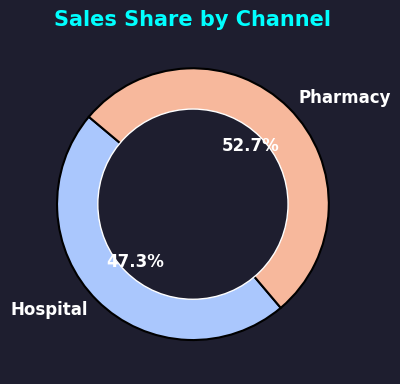

In [55]:
if "Channel" in df.columns:
    channel_sales = df.groupby("Channel")["Sales"].sum()

    # Vibrant color palette
    colors = sns.color_palette("coolwarm", len(channel_sales))

    # Dark background
    plt.figure(figsize=(6,4), facecolor="#1e1e2f")  # normal balanced size

    wedges, texts, autotexts = plt.pie(
        channel_sales,
        labels=channel_sales.index,
        autopct="%1.1f%%",
        startangle=140,
        colors=colors,
        wedgeprops={"edgecolor": "black", "linewidth": 1.5},
        textprops={"fontsize": 12, "weight": "bold", "color": "white"}
    )

    # Donut style (circle in center)
    centre_circle = plt.Circle((0,0),0.70,fc="#1e1e2f")
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Title with contrasting color
    plt.title("Sales Share by Channel", fontsize=15, fontweight="bold", color="cyan")

    plt.tight_layout()
    plt.show()


In [56]:
plt.style.use("dark_background")
sns.set_style("darkgrid")

**Sales Distribution by product class**

/tmp/ipython-input-3528683420.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Product_Class", y="Sales", data=df, palette="coolwarm")


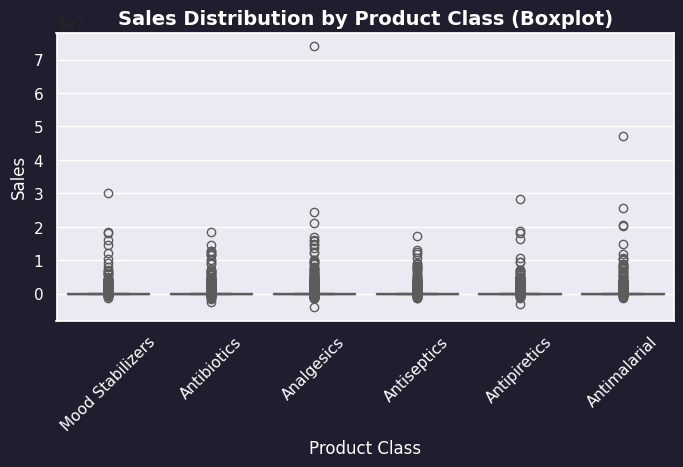

In [61]:
if {"Product_Class","Sales"}.issubset(df.columns):
    plt.figure(figsize=(7,5), facecolor="#1e1e2f")
    sns.boxplot(x="Product_Class", y="Sales", data=df, palette="coolwarm")
    plt.title("Sales Distribution by Product Class (Boxplot)", fontsize=14, fontweight="bold", color="white")
    plt.xticks(rotation=45, color="white")
    plt.yticks(color="white")
    plt.xlabel("Product Class", color="white")
    plt.ylabel("Sales", color="white")
    plt.tight_layout()
    plt.show()

**Corelation Heatmap**

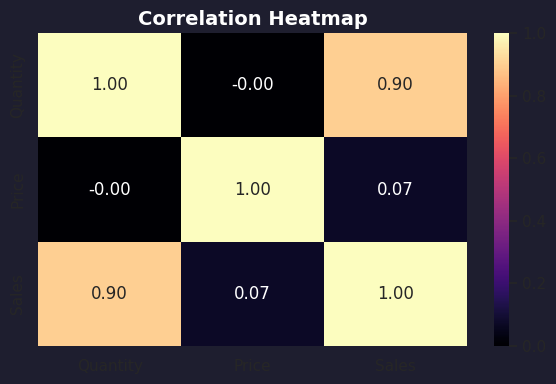

In [64]:
plt.figure(figsize=(6,4), facecolor="#1e1e2f")
sns.heatmap(df[["Quantity","Price","Sales"]].corr(), annot=True, cmap="magma", fmt=".2f")
plt.title("Correlation Heatmap", fontsize=14, fontweight="bold", color="white")
plt.tight_layout()
plt.show()

**Pairwise Relationship**

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been as

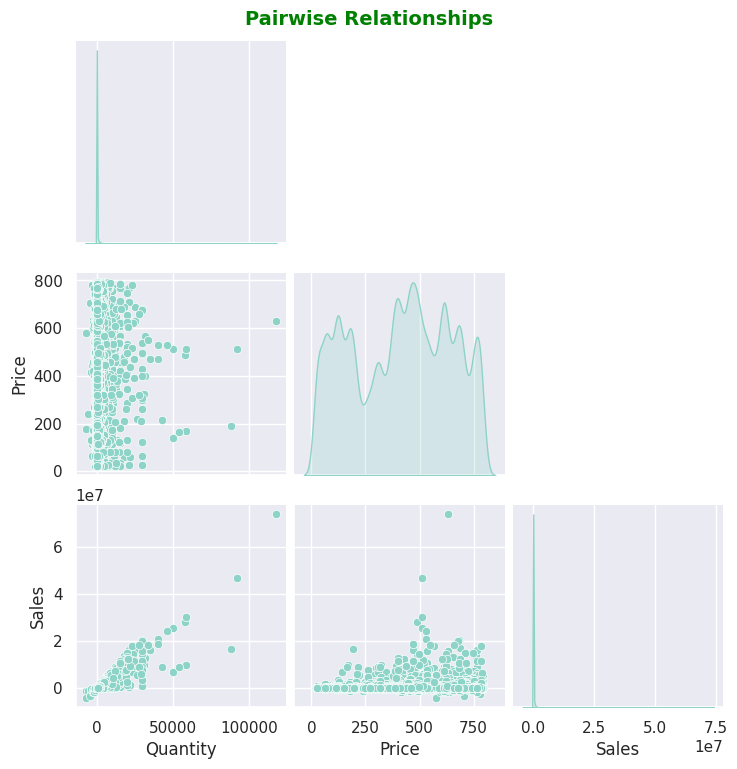

In [66]:
sns.pairplot(df[["Quantity","Price","Sales"]], diag_kind="kde", corner=True, palette="coolwarm")
plt.suptitle("Pairwise Relationships", y=1.02, fontsize=14, fontweight="bold", color="green")
plt.show()

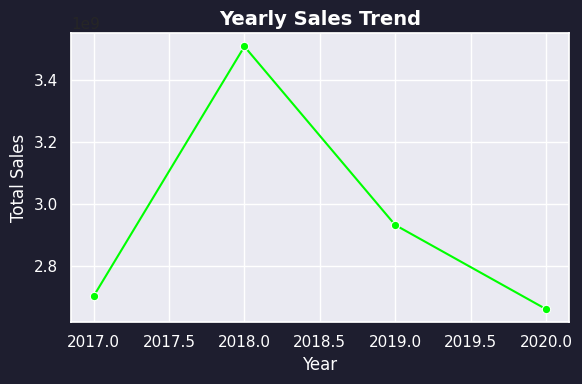

In [69]:
if "Year" in df.columns:
    yearly = df.groupby("Year")["Sales"].sum().reset_index()
    plt.figure(figsize=(6,4), facecolor="#1e1e2f")
    sns.lineplot(x="Year", y="Sales", data=yearly, marker="o", color="lime")
    plt.title("Yearly Sales Trend", fontsize=14, fontweight="bold", color="white")
    plt.xlabel("Year", fontsize=12, color="white")
    plt.ylabel("Total Sales", fontsize=12, color="white")
    plt.xticks(color="white")
    plt.yticks(color="white")
    plt.tight_layout()
    plt.show()